# Community study

In [1]:
import networkx as nx
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import time
import collections
import community
import scipy.io
from networkx.algorithms.link_analysis import hits
from itertools import product
import itertools
#import bct 

#1.Creation of Graph
def createGraph(file):
    G=nx.Graph()

    mat = scipy.io.loadmat(file) #matlab file containing an adjacency matrix for the coactivation 
    #network that includes the weights of each edge and the coordinates of each node in the brain

    content = list(mat.values()) #content[3] weights of the edges; content[4] coordinates
    #print(content[3])
    G = nx.from_numpy_matrix(content[3])
    #values={edge: G[edge[0]][edge[1]]['weight']  for edge in G.edges}
    #print(values)
    #print(G[0][1]['weight'])
    #nx.set_edge_attributes(G, {e:G[e[0]][e[1]]['weight'] for e in G.edges}, 'weight')
    
    #in_degree = dict(nx.degree(G))
    #print(in_degree)
    #nodes = list(G)
    #for i, j in product(range(len(nodes)),range(len(nodes))):
    #M = np.sum([A[i,j]] for i, j in product(range(len(nodes)),range(len(nodes))) ])
   # print("M:", M)
    return G



#determine hubs in network to verify its location in the brain
def hubsComputation(G):
    #with hits algorithm we can determine two values for each node: hubs and authorities. Hubs estimates the node 
    #value based on outgoing links and authorities estimates the node value based on the incoming links
    
    #we can determine each node's hub value, that estimates the value of its links to other pages, to select the most
    #important nodes
    
    #http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture4/lecture4.html
    
    hubs, authorities = hits(G)
    #print("Hubs values:", hubs.items())
    #print("Authorities values:", authorities)
    #these values will be approximately equivalent since we have an undirected graph
    
    hubs_sequence = sorted(hubs.items(),key=itemgetter(1),reverse=True)
    #print("Hubs sequence:", hubs_sequence)
    
    top_ten_hubs_hits = [] 
  
    for i in range(0, 10):  #we want to select top 10 nodes in terms of hub value
        max = 0
        node = 0  
        for j in range(len(hubs_sequence)):      
            if hubs_sequence[j][1] > max: 
                pair = hubs_sequence[j]
                max = hubs_sequence[j][1];
                node = hubs_sequence[j][0]
        
        hubs_sequence.remove(pair);
        top_ten_hubs_hits.append(node) 
          
    print("Top ten nodes, considering hub value:", top_ten_hubs_hits) 
    
    #we can also select the nodes with highest degree since they will be hubs (a lot of links to other links)
    
    degrees = G.degree() #get list with pairs (node, degree)
    #print("Degrees:", degrees)
    degree_sequence = sorted(G.degree(),key=itemgetter(1),reverse=True) #get list with pairs (node, degree) sorted
    #by degree
    #print("Degree sequence:", degree_sequence)
    
    top_ten_hubs_degree = [] 
  
    for i in range(0, 10):  #we want to select top 10 nodes in terms of hub value
        max = 0
        node = 0  
        pair = ()
        for j in range(len(degree_sequence)):      
            if degree_sequence[j][1] > max: 
                pair = degree_sequence[j]
                max = degree_sequence[j][1];
                node = degree_sequence[j][0]
        #print("max:", max)
        #print("node:", node)
        degree_sequence.remove(pair);
        top_ten_hubs_degree.append(node) 
          
    print("Top ten hubs, considering degree:", top_ten_hubs_degree)

G = createGraph('Coactivation_matrix.mat')


hubsComputation(G)

#using R function mni_to_region_name(x,y,z) we can obtain the region where these coordinates are located 
#when the mni coordinate do NOT have a corresponding region -> output closest region and distance to it

#considering the ten hubs, in terms of hits algorithm, we have that:

# 483 - (-2.606837606837601, 12, 55.273504273504270) - "Supp_Motor_Area_L"
# 331 - (-41.091445427728615, -44.525073746312685, 52.147492625368730) - "Parietal_Inf_L"
# 486 - (-4.552301255230120, 17.054393305439334, 47.849372384937240) - "Supp_Motor_Area_L"
# 401 - (-48.193050193050200, 7.088803088803076, 32.308880308880305) - "Precentral_L"
# 236 - (37.201581027667984, 23.873517786561250, 0.197628458498031) - "Insula_R"
# 492 - (7.942446043165461, 14.050359712230204, 49.992805755395680) - "Supp_Motor_Area_R"
# 39 - (-51.270886075949360, 12.126582278481010, 24.997468354430380) - "Frontal_Inf_Oper_L"
# 357 - (-30.687074829931973, -61.748299319727890, 53.251700680272110) - "Parietal_Sup_L"
# 231 - (-31.523809523809520, 23.311355311355300, 1.384615384615387) - "Insula_L"
# 417 - (50.068965517241380, 7.400000000000006, 40.289655172413790) - "Precentral_R"

#considering the ten hubs, in terms of degree, we have that: (8 of the hubs are the same)

# 331 - (-41.091445427728615, -44.525073746312685, 52.147492625368730) - "Parietal_Inf_L"
# 483 - (-2.606837606837601, 12, 55.273504273504270) - "Supp_Motor_Area_L"
# 231 - (-31.523809523809520, 23.311355311355300, 1.384615384615387) - "Insula_L"
# 417 - (50.068965517241380, 7.400000000000006, 40.289655172413790) - "Precentral_R"
# 486 - (-4.552301255230120, 17.054393305439334, 47.849372384937240) - "Supp_Motor_Area_L"
# 236 - (37.201581027667984, 23.873517786561250, 0.197628458498031) - "Insula_R"
# 357 - (-30.687074829931973, -61.748299319727890, 53.251700680272110) - "Parietal_Sup_L"
# 495 - (6.018018018018012, 9.360360360360374, 59.297297297297290) - "Supp_Motor_Area_R"
# 351 - (-24.787003610108300, -64.057761732851990, 56.772563176895320) - "Parietal_Sup_L"
# 401 - (-48.193050193050200, 7.088803088803076, 32.308880308880305) - "Precentral_L"


print("Finish")

Top ten nodes, considering hub value: [482, 330, 485, 400, 235, 491, 38, 356, 230, 416]
Top ten hubs, considering degree: [330, 482, 230, 416, 485, 235, 356, 494, 350, 400]
Finish


In [2]:
#null model random graph to compare

def null_model_Graph(G):
    degree_sequence = [d for n, d in G.degree()]
    null_model = nx.random_degree_sequence_graph(degree_sequence)
    return null_model

G_null = null_model_Graph(G)

Louvain and Newman algorithms

In [3]:
#3.Study of Communities in the Coactivation network
import sys
sys.path.append('python-modularity-maximization')

from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
#from networkx.algorithms.community import greedy_modularity_communities

# Modularity is one measure of the structure of networks or graphs. It was designed to measure the strength of 
#division of a network into modules (also called groups, clusters or communities). 
#Networks with high modularity have dense connections between the nodes within modules but sparse connections 
#between nodes in different modules.

def communities(G):
    #first compute the best partition
    part = community.best_partition(G) #returns dictionary assign a community (integer) to each node
    mod = community.modularity(part, G) #compute modularity
    print("Modularity of the network:", mod)
    
    # Plot, color nodes using community structure
    values = [part.get(node) for node in G.nodes()] #creates a list with the community number for each node in the 
    #order that appears in G.nodes()
        
    # it will use those community numbers to determine the color of the nodes. 
    #All nodes which have been assigned to the same community will be given the same color.
    nx.draw_spring(G, cmap=plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False, dpi=1200)
    plt.figure(figsize=(100, 100))
    plt.show()
    
    #determine number of nodes in each community
    number_communities = max(values)+1
    print("Number of communities:", number_communities)
    count_communities = np.zeros((number_communities,), dtype=int)
    content_communities = []
    for n in range(number_communities):
        content_communities.append([])
    for key,value in part.items():
       # print("Key:", key) #node
       # print("value:", value) #community
        count_communities[value] += 1
        content_communities[value].append(key)
    
    print(count_communities)
    return [part, content_communities] 


#https://zhiyzuo.github.io/python-modularity-maximization/doc/quick-start.html
    
def newman_communities(G):
    
    comm_dict = partition(G)
   # print(comm_dict) #node: # community
    communities_newman = []
    for comm in set(comm_dict.values()):
        communities_newman.append([])
        index_comm = len(communities_newman)-1
        print("Community %d"%comm)
        #values = ','.join(str(v) for v in value_list)
        print(', '.join([str(node) for node in comm_dict if comm_dict[node] == comm]))
        
        for node in comm_dict:
            if (comm_dict[node] == comm):
                  communities_newman[index_comm].append(node)
        
    print('Modularity of such partition for the graph is %.3f' % get_modularity(G, comm_dict))
    return communities_newman

In [3]:
#Communities analysis functions

import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
import pandas as pd

robjects.r['load']("metadata.RData")
matrix=robjects.r['Result']


matrix_list=[]
for i in range(638):
    matrix_list.append(list(matrix[i]))

def simplify(matrix):
    labels=[]
    for index, label in enumerate(matrix):
        labels.append(label[0].split("_")[0])   
    return labels

labels=simplify(matrix_list)        

def comun_dist(communities):
    
    for i in range(len(communities)):
        
        sub_metadata=[]
        for node in communities[i]:
            sub_metadata.append(labels[node])
            
        df = pd.DataFrame(sub_metadata)

        dist=df[0].value_counts() 

        dist.plot(kind='bar')
        title="Community {}".format(i)
        plt.title(title)
        plt.show()
        
def igraph_analysis(dendogram):
    vertex=dendogram.as_clustering()
    print("Modularity:", vertex.modularity)
    comm=vertex.subgraphs()
    print("Number of communities:", len(comm))


Results for Louvain community detection algorithm

Modularity of the network: 0.467445852922999


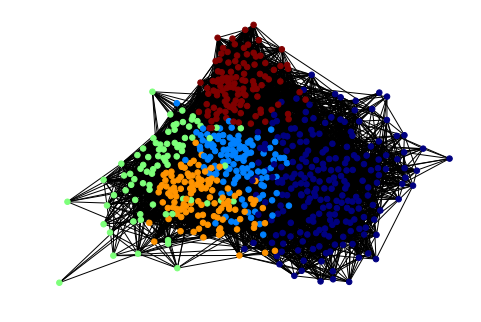

Number of communities: 5
[219 113  78 116 112]
[[0, 1, 4, 8, 9, 11, 13, 14, 21, 22, 23, 24, 47, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 61, 81, 82, 83, 84, 85, 86, 90, 92, 99, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 117, 132, 134, 136, 137, 138, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 153, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 187, 188, 189, 190, 191, 196, 198, 199, 200, 201, 205, 207, 209, 210, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 276, 287, 294, 295, 297, 299, 306, 307, 310, 311, 312, 313, 314, 315, 316, 317, 318, 427, 428, 431, 432, 438, 442, 443, 445, 446, 448, 449, 451, 466, 467, 468, 469, 470, 471, 499, 508, 512, 514, 515, 516, 517, 518, 519, 520, 522, 523, 524, 529, 530, 531, 533, 534, 535, 538, 540, 541, 542, 543, 544, 545, 546, 547, 548, 550, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574,

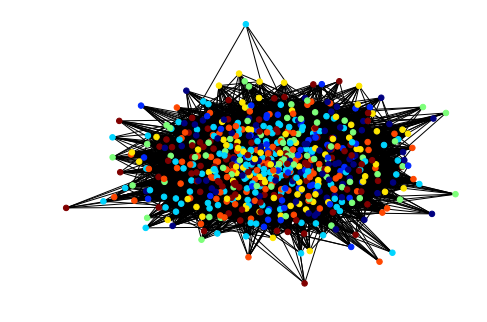

Number of communities: 7
[ 86  56 131  75  85  95 110]


In [9]:
partitions_louvain, comm_louvain= communities(G)

print(comm_louvain)

partitions_louvain_null, comm_louvain_null = communities(G_null)



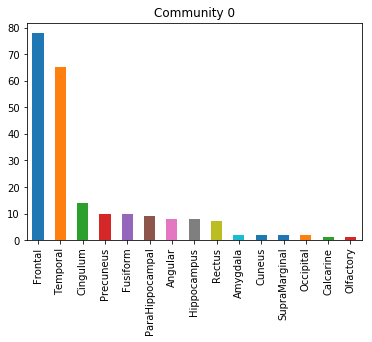

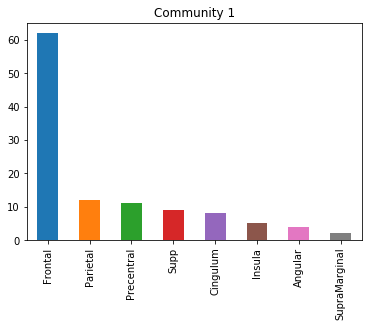

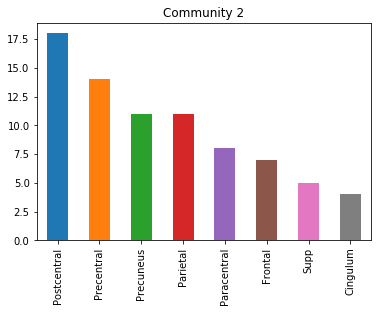

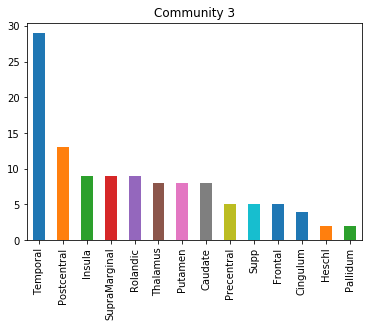

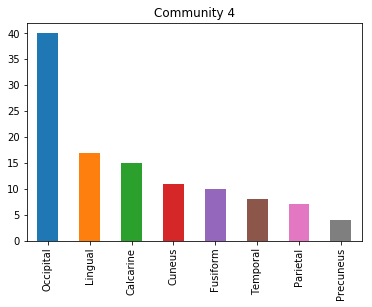

In [18]:
comm_louvain=[[0, 1, 4, 8, 9, 11, 13, 14, 21, 22, 23, 24, 47, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 61, 81, 82, 83, 84, 85, 86, 90, 92, 99, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 117, 132, 134, 136, 137, 138, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 153, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 187, 188, 189, 190, 191, 196, 198, 199, 200, 201, 205, 207, 209, 210, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 276, 287, 294, 295, 297, 299, 306, 307, 310, 311, 312, 313, 314, 315, 316, 317, 318, 427, 428, 431, 432, 438, 442, 443, 445, 446, 448, 449, 451, 466, 467, 468, 469, 470, 471, 499, 508, 512, 514, 515, 516, 517, 518, 519, 520, 522, 523, 524, 529, 530, 531, 533, 534, 535, 538, 540, 541, 542, 543, 544, 545, 546, 547, 548, 550, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 577, 578, 579, 581, 582, 583, 584, 585, 586, 587, 588, 589, 592, 593, 594, 595, 609, 632, 636, 637], [2, 3, 7, 16, 19, 38, 40, 42, 44, 45, 50, 57, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 87, 88, 89, 91, 93, 94, 95, 96, 97, 98, 100, 103, 104, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 143, 152, 154, 160, 167, 169, 181, 184, 219, 230, 231, 232, 235, 236, 293, 296, 298, 327, 328, 330, 331, 332, 333, 334, 344, 346, 347, 348, 356, 397, 398, 400, 401, 403, 407, 416, 418, 421, 482, 483, 484, 485, 491, 492, 493, 494, 509, 511, 633, 634, 635], [5, 10, 15, 17, 135, 139, 140, 185, 186, 192, 193, 319, 320, 321, 322, 323, 324, 325, 326, 329, 345, 349, 351, 354, 355, 359, 360, 361, 363, 364, 366, 368, 369, 372, 375, 378, 380, 381, 382, 386, 387, 388, 389, 390, 391, 394, 395, 396, 402, 404, 406, 408, 409, 410, 412, 413, 415, 417, 419, 422, 423, 424, 425, 426, 429, 434, 435, 436, 437, 439, 440, 441, 444, 486, 487, 489, 490, 498], [6, 12, 18, 20, 37, 39, 41, 43, 46, 213, 214, 228, 229, 233, 234, 237, 238, 239, 240, 241, 308, 309, 367, 370, 371, 373, 374, 376, 377, 379, 383, 384, 385, 392, 393, 399, 405, 411, 414, 420, 452, 453, 454, 455, 462, 463, 464, 465, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 488, 495, 496, 497, 500, 501, 502, 503, 504, 505, 506, 507, 510, 525, 526, 527, 528, 549, 552, 553, 564, 590, 591, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631], [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 194, 195, 197, 202, 203, 204, 206, 208, 211, 212, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 292, 300, 301, 302, 303, 304, 305, 335, 336, 337, 338, 339, 340, 341, 342, 343, 350, 352, 353, 357, 358, 362, 365, 430, 433, 447, 450, 456, 457, 458, 459, 460, 461, 513, 521, 532, 536, 537, 539, 551, 576, 580]]

comun_dist(comm_louvain)

Modularity of the network: 0.4286062040448628


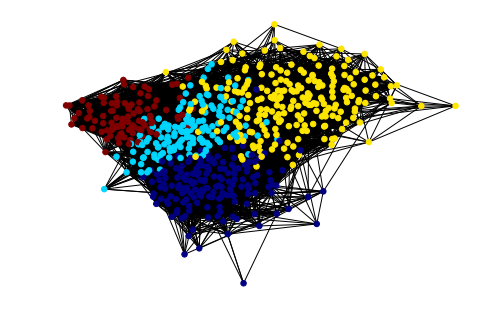

Number of communities: 4
[171 147 223  97]
Modularity of the network: 0.43069587423989913


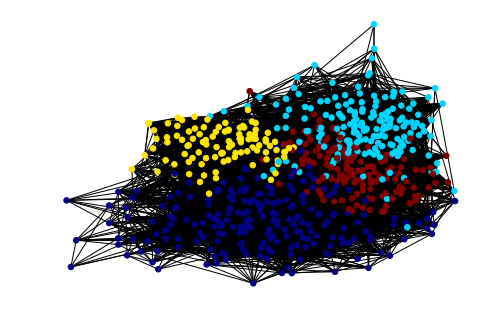

Number of communities: 4
[216 178 104 140]
Modularity of the network: 0.43076058483852075


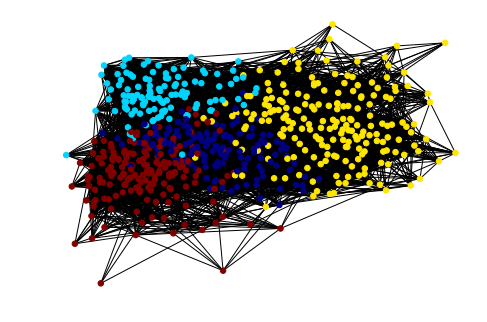

Number of communities: 4
[145 114 204 175]
Modularity of the network: 0.42801756173145356


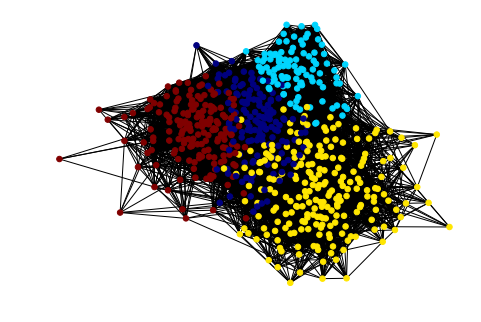

Number of communities: 4
[142 103 224 169]
Modularity of the network: 0.42974704634926353


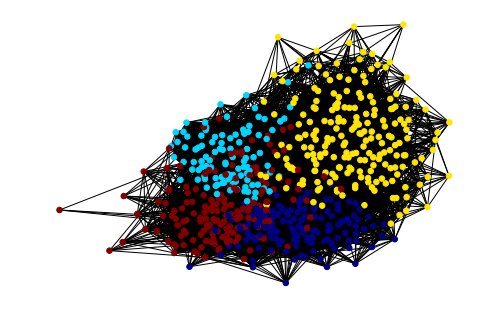

Number of communities: 4
[148 105 207 178]
Modularity of the network: 0.4298294527273546


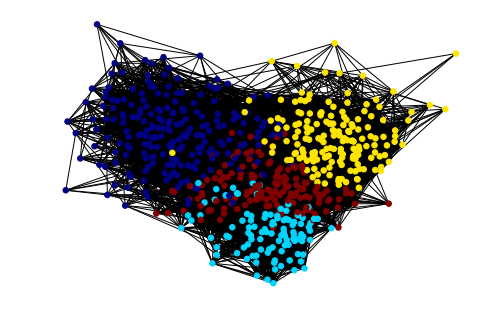

Number of communities: 4
[215 104 170 149]
Modularity of the network: 0.43101238899148686


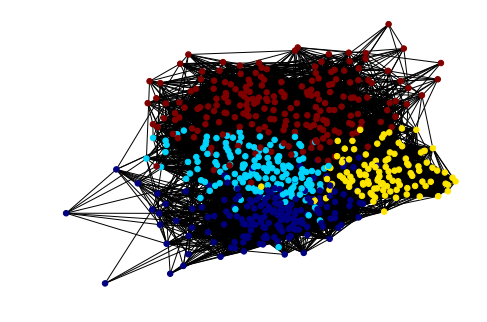

Number of communities: 4
[173 146 111 208]
Modularity of the network: 0.4286983152110265


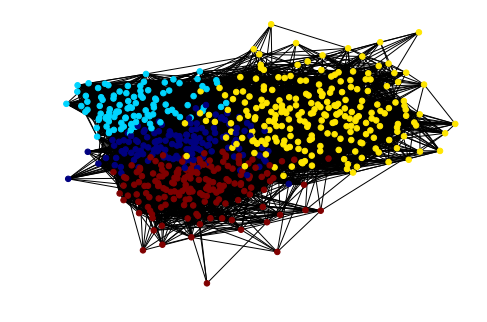

Number of communities: 4
[140 102 228 168]
Modularity of the network: 0.4308936411873339


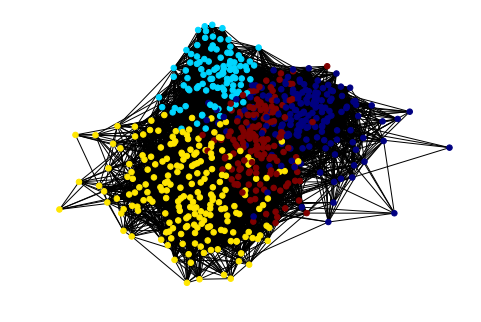

Number of communities: 4
[177 104 208 149]
Results: [{0, 1, 514, 512, 4, 516, 517, 518, 8, 9, 519, 11, 520, 522, 14, 523, 524, 17, 526, 529, 530, 21, 22, 23, 24, 531, 533, 534, 535, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 554, 555, 556, 558, 47, 48, 49, 559, 51, 52, 53, 54, 55, 56, 560, 58, 59, 563, 565, 566, 567, 569, 570, 571, 572, 573, 574, 575, 577, 72, 578, 579, 581, 582, 583, 584, 585, 592, 81, 82, 83, 84, 85, 86, 593, 594, 595, 90, 609, 99, 101, 105, 108, 117, 632, 634, 636, 637, 132, 134, 136, 137, 138, 141, 142, 144, 146, 147, 148, 149, 150, 151, 153, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 168, 170, 171, 172, 173, 175, 176, 177, 179, 180, 182, 183, 187, 188, 189, 190, 191, 198, 199, 200, 205, 209, 210, 217, 218, 220, 221, 222, 223, 225, 226, 227, 561, 276, 287, 294, 295, 297, 299, 306, 307, 310, 311, 313, 316, 317, 318, 586, 587, 588, 589, 425, 427, 428, 431, 435, 438, 442, 443, 445, 446, 448, 449, 451, 466, 467, 468, 469, 470, 471, 499, 508}, {5

In [41]:
#study of communities with different order for nodes, so as to find nodes that belong always to the same communities
# and nodes in the borderline
from random import shuffle
from numpy import sort

def generateCommunity(file):
    
    G = createGraph(file)
    #print(list(G.edges()))
    #[e for e in G.edges()]
    edges = list(G.edges())
    shuffle(edges)
    #print(type(edges)==list)
   # print(edges)
    shuffle_G = nx.Graph()
    shuffle_G.add_edges_from(edges)
    
    [part_louvain, content_communities_louvain] = communities(shuffle_G)
    
    return [part_louvain, content_communities_louvain]

communities_iter = []
communities_iter.append(comm_louvain)
for i in range(9):
    [part_louvain, communities_louvain] = generateCommunity('Coactivation_matrix.mat') 
    for i in range(len(communities_louvain)): #go to each row that corresponds to a community and sort columns
        communities_louvain[i].sort()
    communities_louvain = sorted(communities_louvain, key=lambda x: x[0])
    #print("Communities:", communities_louvain)
    #communities_louvain.sort(order=['f0'], axis=0)
    communities_iter.append(communities_louvain)
#sort per columns 
#communities_iter.sort(axis=1,)    
#print("First case:", communities_iter[0]) #what to do???? 5 communities here and 4 in the other
communities_constant_nodes = []
for i in range(4):
    result = set(communities_iter[1][i]) & set(communities_iter[2][i]) & set(communities_iter[3][i]) & set(communities_iter[4][i]) & set(communities_iter[5][i])& set(communities_iter[6][i]) & set(communities_iter[7][i]) & set(communities_iter[8][i]) & set(communities_iter[9][i])
    communities_constant_nodes.append(result)
    
print("Results:", communities_constant_nodes)

#como posso comparar mesmo entre estes 4 -> ver intersecções sucessivas à medida que vou buscando cada

0.056313795066863646
13026
18625
5599
Modularity of the network: 0.608688126089301


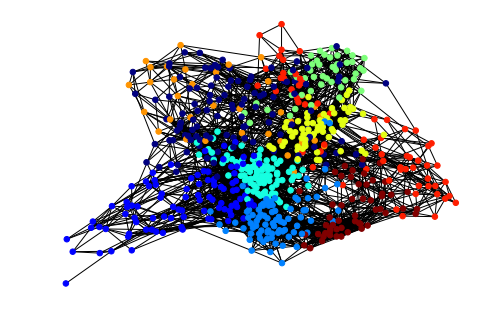

Number of communities: 9
[115  92  81  92  44  64  34  63  53]


In [32]:
#Test communities obtained by Louvain method considering only edges with

#to define threshold for weight
def averageWeight(G):
    sum_weight = 0
    for u, v, w in G.edges(data = 'weight'):
        sum_weight += w
    E = G.number_of_edges()
    av_weight = sum_weight/E
    return av_weight

def processGraph(G, av_weight):
    threshold = av_weight
    print(threshold)
    list = []
    for u, v, w in G.edges(data = 'weight'):
        if (w < threshold):
           list.append((u,v))
    print(len(list))
    print(G.number_of_edges())
    G.remove_edges_from(list)
    print(G.number_of_edges())
    
    return G

av_weight = averageWeight(G)
#processedG = processGraph(G,av_weight)
#partitions_louvain, comm_louvain= communities(processedG)
#partitions_louvain, comm_louvain= communities(G)

#arising of giant component -> quando é que quebra -> distribuiçao de componentes -> indica threshold, um pouco abaixo do breaking point
#rede com igual distribuiçao mas links aleatorios -> aplicar e ver modularidade (gerar null model)
#rede igual excepto nos padroes de conectividade rewiring model networkx
#comparação com este null model!
# distribuiçao de degree pode ser forte para APL ser igual -> sempre small world
#-> se der igual modularidade efeito da degree distribution e nao da densidade do grafo
#modularidade baixa devido a densidade do grafo (menos sparse do que normal para small world ) se modularidade do null model for mais baixa que a nossa

In [ ]:
comm_newman = newman_communities(G)

comm_newman_null = newman_communities(G_null)

#print(comm_newman)

Community 3
5, 6, 10, 12, 15, 18, 20, 37, 39, 41, 43, 46, 139, 185, 193, 213, 214, 228, 229, 233, 234, 237, 238, 239, 240, 241, 308, 309, 319, 320, 321, 322, 323, 324, 325, 326, 329, 354, 355, 363, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 399, 402, 404, 405, 406, 408, 409, 410, 411, 412, 413, 414, 415, 417, 418, 419, 420, 422, 423, 424, 426, 429, 437, 439, 441, 452, 453, 454, 455, 462, 463, 464, 465, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 486, 487, 488, 489, 490, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 510, 511, 525, 527, 528, 553, 564, 590, 591, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 610, 611, 612, 613, 614, 615, 616, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631
Community 4
2, 3, 7, 13, 16, 19, 38, 40, 42, 44, 45, 50, 57, 60, 62, 65, 66, 68, 69, 70, 73, 74, 75, 76, 77, 78, 79, 80, 87, 88, 91, 93, 9

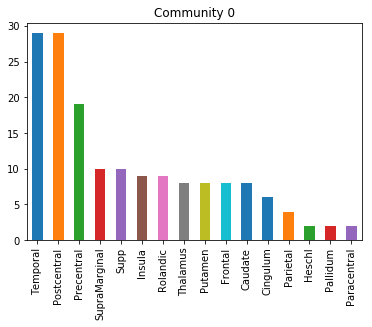

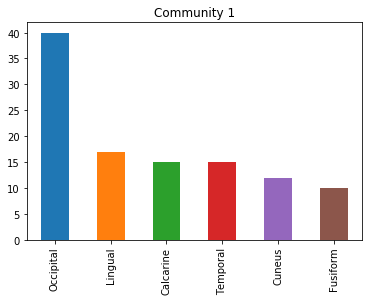

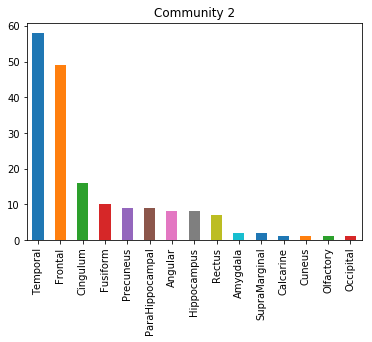

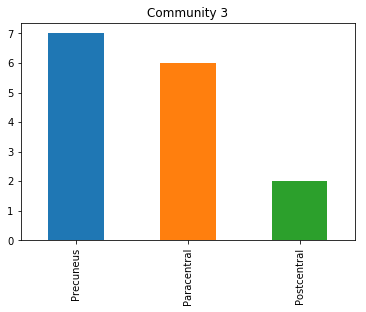

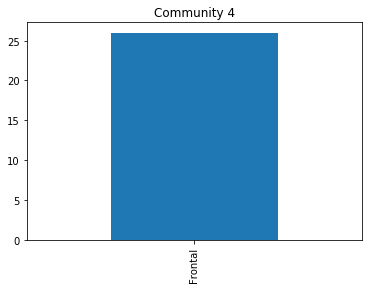

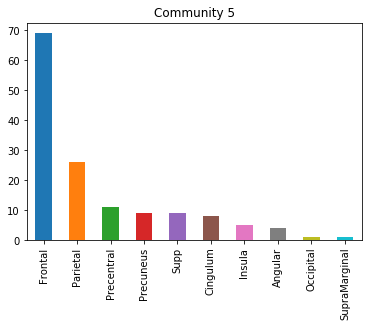

In [20]:
comm_newman=[[5, 6, 10, 12, 18, 20, 37, 39, 41, 43, 46, 139, 185, 193, 213, 214, 228, 229, 233, 234, 237, 238, 239, 240, 241, 308, 309, 319, 320, 329, 354, 355, 363, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 389, 391, 392, 393, 394, 395, 396, 399, 402, 404, 405, 406, 408, 409, 410, 411, 412, 413, 414, 415, 417, 419, 420, 422, 423, 424, 452, 453, 454, 455, 462, 463, 464, 465, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 486, 487, 488, 489, 490, 495, 496, 497, 498, 500, 501, 502, 503, 504, 505, 506, 507, 510, 511, 525, 526, 527, 528, 549, 552, 553, 564, 590, 591, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631], [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 194, 195, 197, 202, 203, 204, 206, 208, 211, 212, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 300, 301, 302, 304, 305, 335, 336, 337, 338, 339, 340, 341, 342, 343, 442, 456, 457, 458, 459, 460, 461, 513, 514, 515, 521, 532, 536, 537, 538, 539, 541, 550, 551, 557, 570, 576, 580],[0, 1, 4, 8, 9, 11, 13, 14, 15, 17, 21, 22, 23, 24, 52, 54, 81, 82, 83, 84, 85, 86, 90, 99, 101, 105, 117, 134, 136, 137, 138, 141, 142, 144, 146, 147, 148, 149, 150, 151, 153, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 168, 170, 171, 175, 179, 180, 182, 183, 187, 188, 189, 190, 191, 196, 198, 199, 200, 201, 205, 207, 209, 210, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 276, 294, 295, 297, 299, 306, 307, 310, 311, 312, 313, 314, 315, 316, 317, 318, 427, 428, 431, 438, 443, 445, 446, 448, 449, 451, 466, 467, 468, 469, 470, 471, 499, 508, 512, 516, 517, 518, 519, 520, 522, 523, 524, 529, 530, 531, 533, 534, 535, 540, 542, 543, 544, 545, 546, 547, 548, 554, 555, 556, 558, 559, 560, 561, 562, 563, 565, 566, 567, 568, 569, 571, 572, 573, 574, 575, 577, 578, 579, 581, 582, 583, 584, 585, 586, 587, 588, 589, 592, 593, 594, 595, 609, 632, 636, 637], [321, 322, 323, 324, 325, 326, 388, 390, 425, 426, 429, 435, 437, 439, 441],[47, 48, 49, 51, 53, 55, 56, 58, 59, 61, 72, 77, 106, 107, 108, 109, 110, 111, 112, 113, 172, 173, 174, 176, 177, 178],[2, 3, 7, 16, 19, 38, 40, 42, 44, 45, 50, 57, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 79, 80, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 100, 102, 103, 104, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 140, 143, 145, 152, 154, 160, 167, 169, 181, 184, 186, 192, 219, 230, 231, 232, 235, 236, 293, 296, 298, 303, 327, 328, 330, 331, 332, 333, 334, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 356, 357, 358, 359, 360, 361, 362, 364, 365, 397, 398, 400, 401, 403, 407, 416, 418, 421, 430, 432, 433, 434, 436, 440, 444, 447, 450, 482, 483, 484, 485, 491, 492, 493, 494, 509, 633, 634, 635]]
comun_dist(comm_newman)

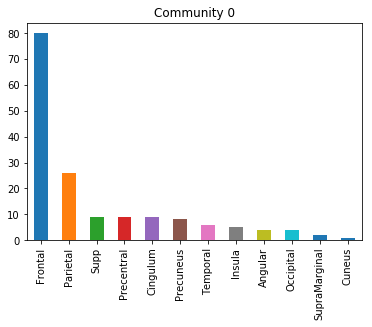

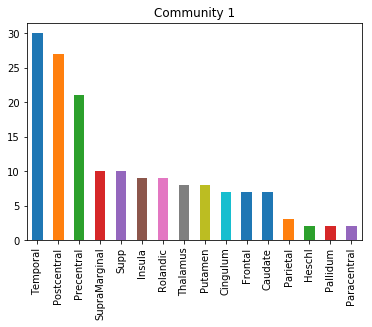

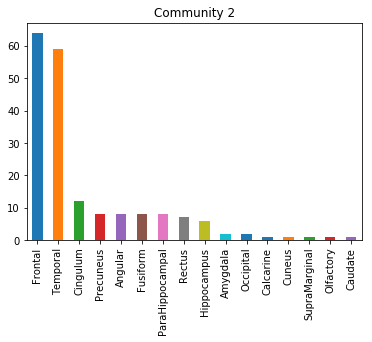

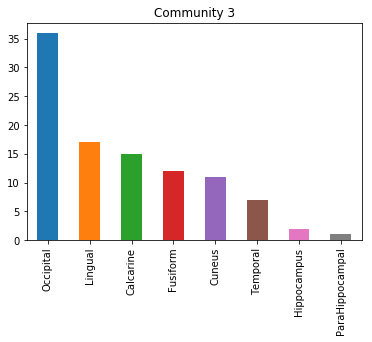

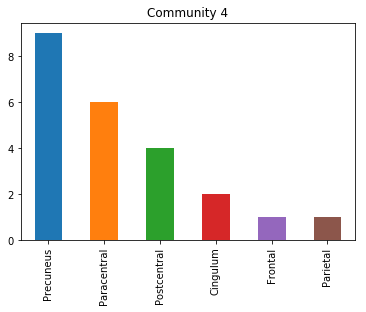

Modularity: 0.4280498024413315


In [21]:
import igraph as ig
from igraph import *

Gi= ig.Graph.Adjacency((nx.to_numpy_matrix(G) > 0).tolist())

comm_infomap=Gi.community_infomap()

comun_dist(comm_infomap)

print("Modularity:", Gi.modularity(comm_infomap))

Gi_null= ig.Graph.Adjacency((nx.to_numpy_matrix(G_null) > 0).tolist())

comm_infomap=Gi_null.community_infomap()

print("Modularity:", Gi_null.modularity(comm_infomap))

In [20]:
#Replace labels of matrix with numbers 
matrix_list=[]
for i in range(638):
    matrix_list.append(list(matrix[i]))

matrix_df = pd.DataFrame(list(matrix_list))

print(matrix_df[0])
print(matrix_df[0].unique())
real_communities=pd.Categorical(matrix_df[0], categories=matrix_df[0].unique()).codes

print(real_communities)
print(np.unique(real_communities))

0       Cingulum_Ant_R
1       Cingulum_Ant_R
2       Cingulum_Ant_R
3       Cingulum_Ant_R
4       Cingulum_Ant_R
5       Cingulum_Mid_L
6       Cingulum_Mid_L
7       Cingulum_Mid_L
8       Cingulum_Mid_L
9       Cingulum_Mid_L
10      Cingulum_Mid_L
11      Cingulum_Mid_L
12      Cingulum_Mid_L
13      Cingulum_Mid_R
14      Cingulum_Mid_R
15      Cingulum_Mid_R
16      Cingulum_Mid_R
17      Cingulum_Mid_R
18      Cingulum_Mid_R
19      Cingulum_Mid_R
20      Cingulum_Mid_R
21      Cingulum_Mid_R
22     Cingulum_Post_L
23     Cingulum_Post_L
24         Precuneus_R
25            Cuneus_L
26            Cuneus_L
27            Cuneus_L
28            Cuneus_L
29            Cuneus_L
            ...       
608     Temporal_Sup_R
609     Temporal_Sup_R
610     Temporal_Sup_R
611     Temporal_Sup_R
612     Temporal_Sup_R
613     Temporal_Sup_R
614     Temporal_Sup_R
615     Temporal_Sup_R
616     Temporal_Sup_R
617     Temporal_Sup_R
618     Temporal_Sup_R
619     Temporal_Sup_R
620        

In [7]:
#Replace labels of matrix with numbers 
#Defined previously
#labels=simplify(matrix_list)        

matrix_df = pd.DataFrame(labels)
real_communities_simplified=pd.Categorical(matrix_df[0], categories=matrix_df[0].unique()).codes

#print(real_communities_simplified)
print(np.unique(real_communities_simplified))

print(list(real_communities_simplified))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

In [7]:
NMI = compare_communities(partitions_louvain.values(), real_communities, method="nmi")

print(NMI)

0.3624167800971483


In [33]:
NMI = compare_communities(partitions_louvain.values(), real_communities_simplified, method="nmi")

print(NMI)

0.3856991716404372


In [8]:
NMI2= compare_communities(comm_infomap.membership, real_communities, method="nmi")

print(NMI2)

0.36007030270275847


In [34]:
NMI2= compare_communities(comm_infomap.membership, real_communities_simplified, method="nmi")

print(NMI2)

0.3616028629035223


In [31]:
list_comm_newman=[0]*638

i=0
for com in comm_newman:
    for node in com:
        list_comm_newman[int(node)]=i
    i+=1

print(list_comm_newman)



[2, 2, 5, 5, 2, 0, 0, 5, 2, 2, 0, 2, 0, 2, 2, 2, 5, 2, 0, 5, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 5, 0, 5, 0, 5, 0, 5, 5, 0, 4, 4, 4, 5, 4, 2, 4, 2, 4, 4, 5, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 2, 2, 2, 2, 2, 2, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 2, 5, 5, 5, 2, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 2, 2, 2, 0, 5, 2, 2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 5, 2, 5, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 5, 2, 5, 2, 2, 4, 4, 4, 2, 4, 4, 4, 2, 2, 5, 2, 2, 5, 0, 5, 2, 2, 2, 2, 2, 5, 0, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 0, 0, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 5, 5, 5, 0, 0, 5, 5, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 2, 2, 5, 2, 5, 2, 1, 1, 1, 5, 1, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 5, 5, 0, 5, 5, 5, 

In [32]:
NMI3= compare_communities(list_comm_newman, real_communities, method="nmi")

print(NMI3)

0.3802893727945323


In [36]:
NMI3= compare_communities(list_comm_newman, real_communities_simplified, method="nmi")

print(NMI3)

0.3992567707056222


In [10]:
#MORE COMMUNITY ALGORITHMS

Edges=list(G.edges)

Gi=ig.Graph(Edges, directed=False)

weights=[]
for edge in list(G.edges):
    weights.append(G.edges[edge]['weight'])


In [36]:
from igraph import *
#communities in igraph: https://igraph.org/python/doc/igraph.Graph-class.html

#Clauset, MEJ Newman and C Moore
comm_fastgreedy_igraph = Gi.community_fastgreedy(weights=weights)
igraph_analysis(comm_fastgreedy_igraph)

Modularity: 0.4139883186133172
Number of communities: 5


In [37]:
comm_between_igraph = Gi.community_edge_betweenness(directed=False, weights=weights)
igraph_analysis(comm_between_igraph)

Modularity: 0.33295133449090064
Number of communities: 174


In [42]:
#may be the same as G-newman
comm_between87_igraph = Gi.community_edge_betweenness(clusters=87, directed=False, weights=weights)
igraph_analysis(comm_between87_igraph)

Modularity: 0.1867325382846379
Number of communities: 87


In [43]:
comm_spinglass_igraph=Gi.community_spinglass(weights=weights)
print("Modularity:", comm_spinglass_igraph.modularity)
comm=comm_spinglass_igraph.subgraphs()
print("Number of communities:", len(comm))

Modularity: 0.47390912417194236
Number of communities: 7


In [44]:
comm_walktrap_igraph=Gi.community_walktrap(weights=weights)
igraph_analysis(comm_walktrap_igraph)

Modularity: 0.425819172866439
Number of communities: 6
